In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
from gflownet.gflownet import GFlowNet
from policy import ForwardPolicy, BackwardPolicy
from setGenerationEnv import SetGenerationEnv
from gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size = 4
nActions = 15
losses = []
rewards = []
flows = []


def train(batch_size, num_epochs):
    setEnv = SetGenerationEnv(size, nActions)
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=32, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 0.1},
    ],
    lr=5e-4)
    
    for i in (p := tqdm(range(num_epochs))):
        s0 = torch.full(size=(batch_size, setEnv.state_dim), fill_value=0.1).float()
        curr0 = torch.zeros(batch_size)
        s, log = model.sample_states(s0, curr0, return_log=True)
      

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)
        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f}")

    return model, losses, rewards, flows

batch_size = 2
num_epochs = 1

model, losses, rewards, flows = train(batch_size, num_epochs)

71.003: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.86it/s]

Curr tensor([0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([0., 0.])
Curr tensor([0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,

Text(0.5, 1.0, 'Log Total Flow (logZ)')

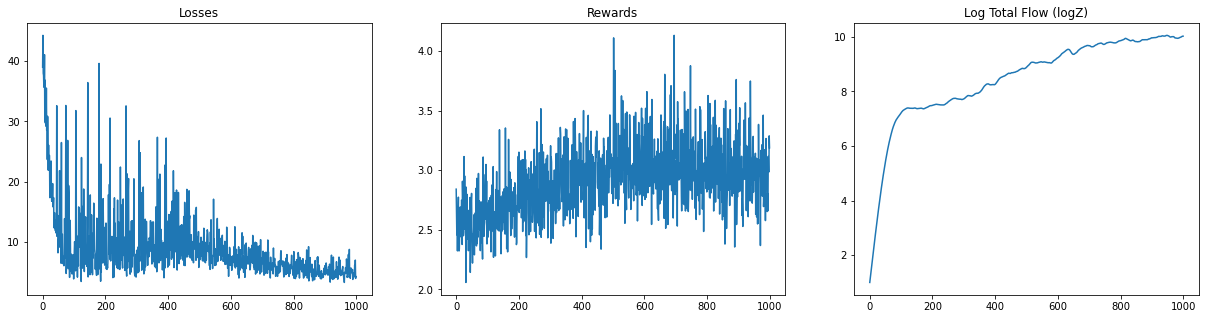

In [18]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(rewards)
ax[1].set_title("Rewards")
ax[2].plot(flows)
ax[2].set_title("Log Total Flow (logZ)")